In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.tsa.deterministic import DeterministicProcess

In [2]:
from ts_tools import *

In [3]:
#load train
store_sales = pd.read_csv(
    'input_data/train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
# store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index('date').sort_index()

#load test
test = pd.read_csv(
    'input_data/test.csv',
    usecols=['store_nbr', 'family', 'date', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True
)
# test['date'] = test.date.dt.to_period('D')
test = test.set_index('date').sort_index()

In [4]:
full = pd.concat([store_sales, test])

In [5]:
full['day'] = full.index.day_of_week
full['week'] = full.index.week
full['month'] = full.index.month
full['year'] = full.index.year

/tmp/ipykernel_24171/225413157.py:2: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  full['week'] = full.index.week


## Look at the data

In [6]:
#Look at the data
fl = full.loc[full.store_nbr == '1']
fl = fl.groupby(['date', 'family'])['sales'].sum().unstack('family')

In [7]:
cols = fl.columns

#### $Total$

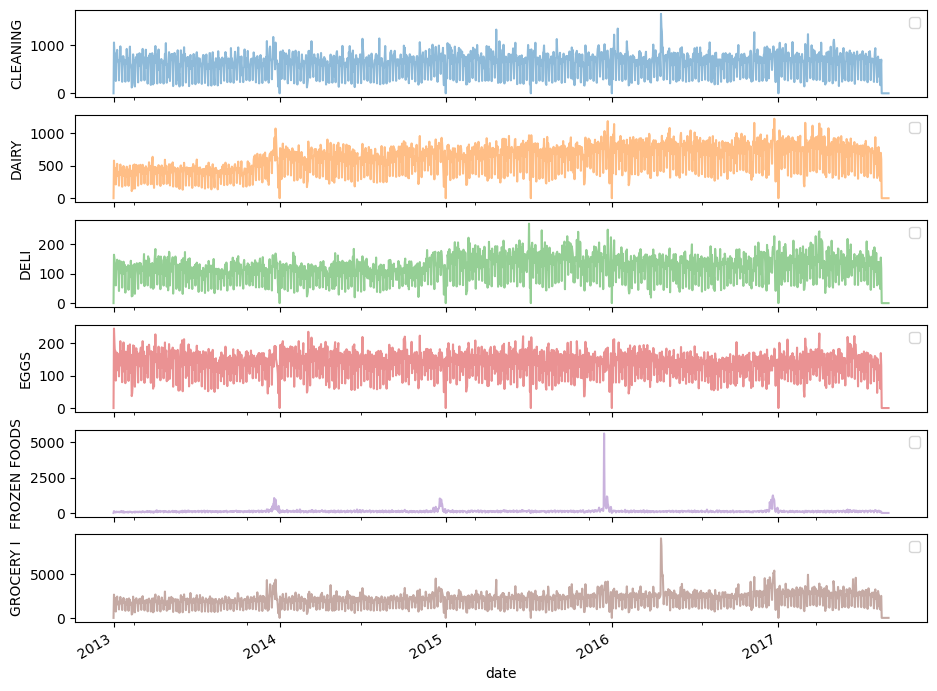

In [8]:
axs = fl.loc[:, cols[7:13]].plot(
    subplots=True, sharex=True, figsize=(11, 9), alpha=0.5,
)
for ax, family in zip(axs, cols[7:13]):
    ax.legend([])
    ax.set_ylabel(family)

###### `There is a little ascending trend and yearly cycles`

#### $Yearly$

In [9]:
fl = fl.loc['2015']

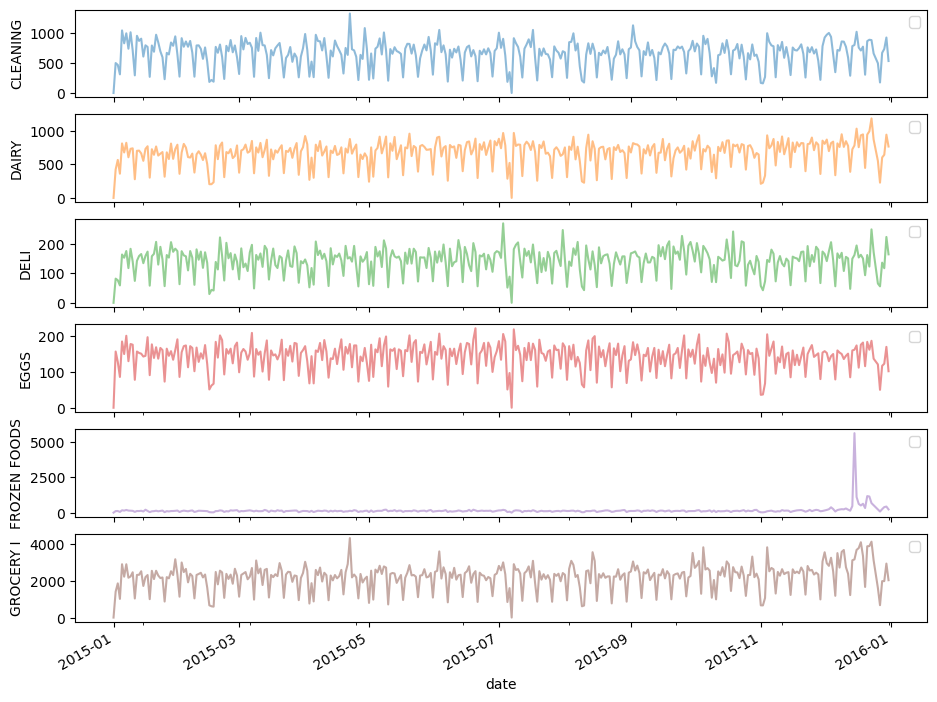

In [10]:
axs = fl.loc[:, cols[7:13]].plot(
    subplots=True, sharex=True, figsize=(11, 9), alpha=0.5,
)
for ax, family in zip(axs, cols[7:13]):
    ax.legend([])
    ax.set_ylabel(family)

###### `There're might be weekly cycles`

## Seasonal check

In [11]:
fl = full.loc[full.store_nbr == '1']
fl = fl.loc['2015']

#### Check for weekly cycles

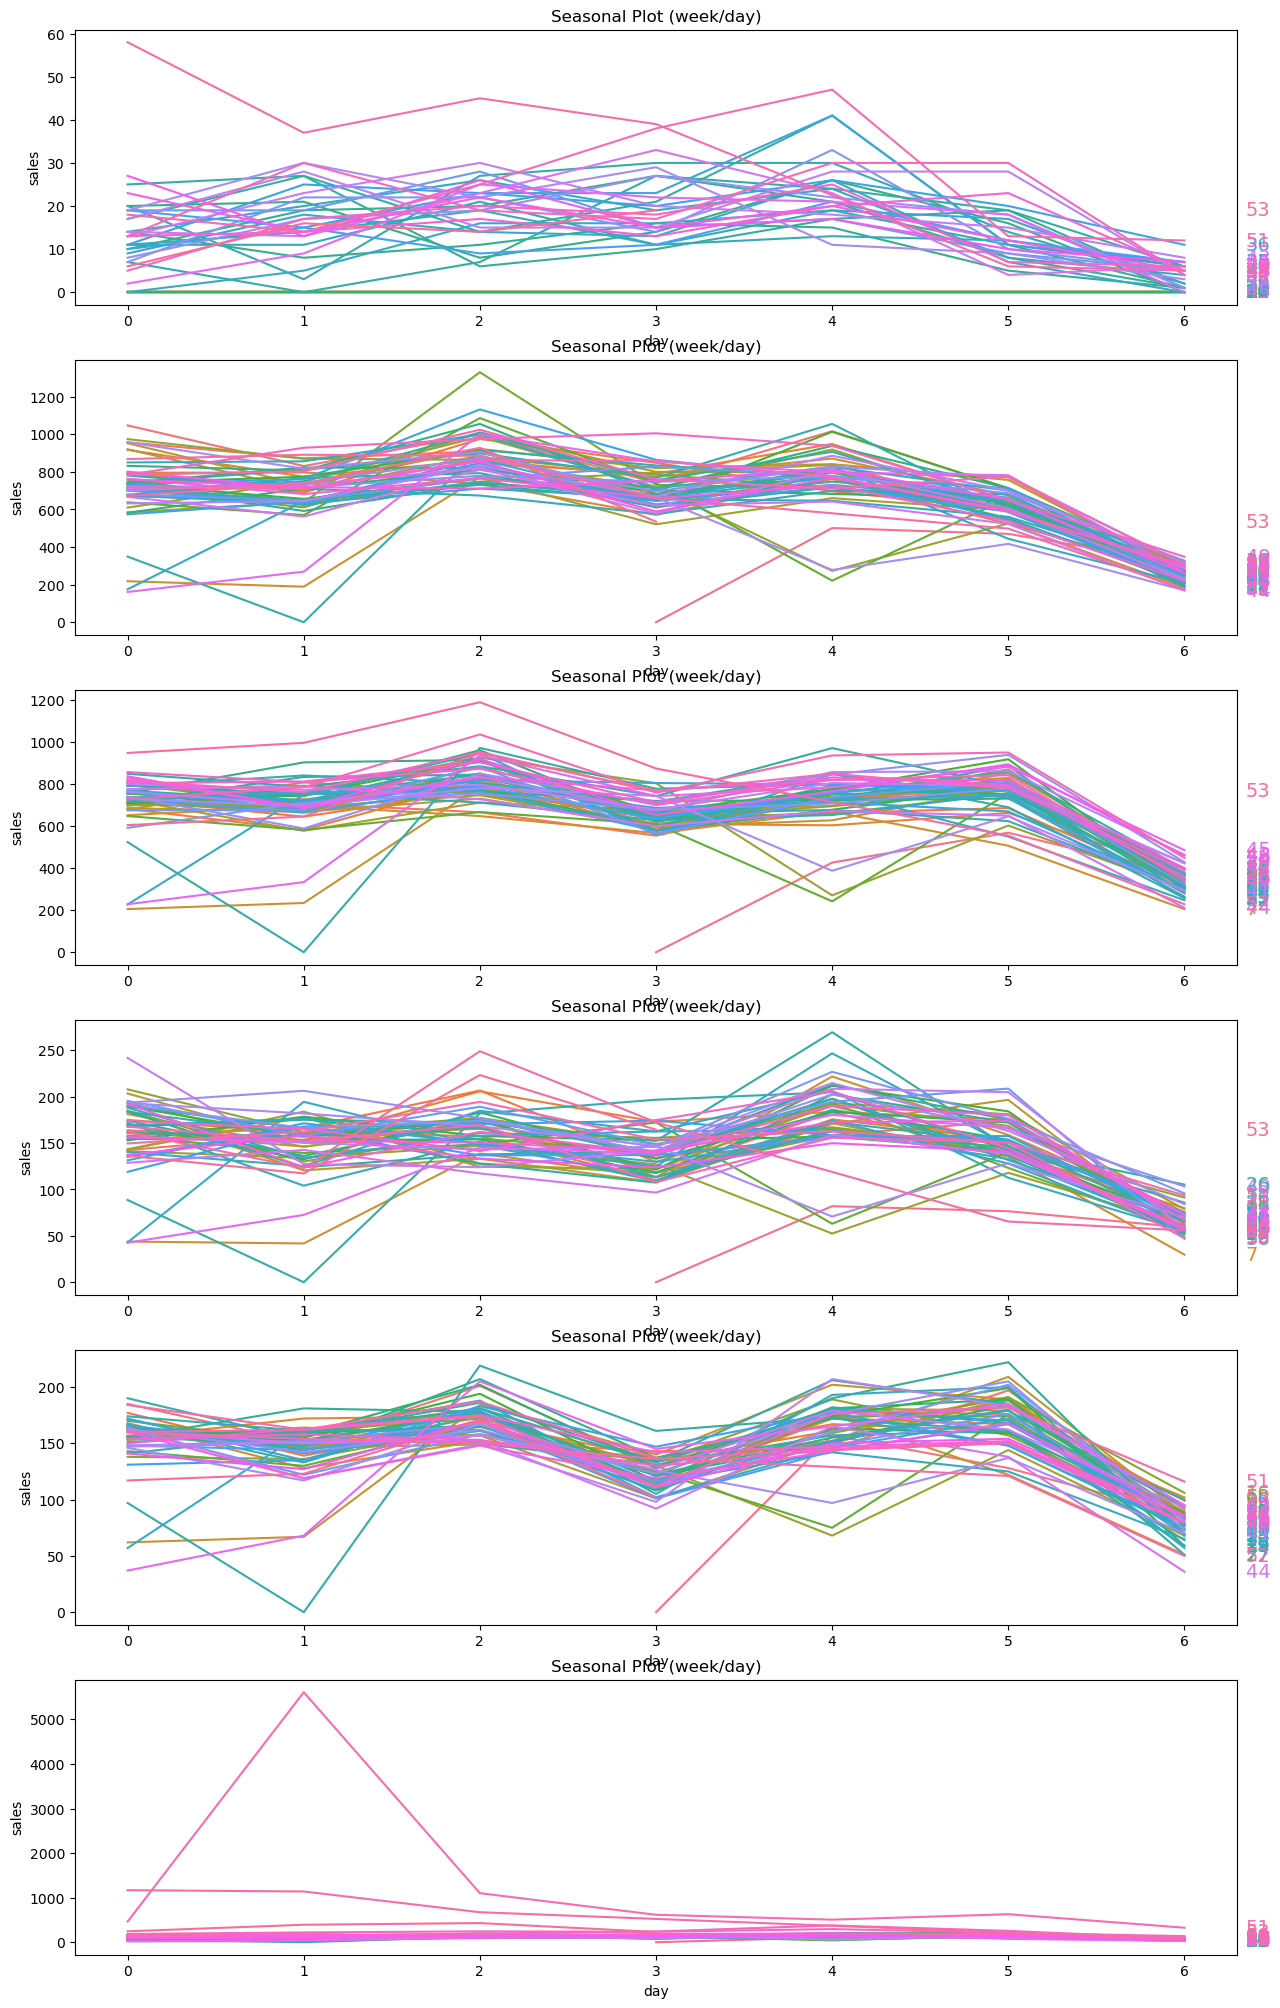

In [12]:
fig, axes = plt.subplots(6, 1, figsize = (15,25))
for n, ax in enumerate(axes):
    seasonal_plot(X = fl.loc[fl.family == cols[n+6], ['week', 'day']],
                  y = fl.loc[fl.family == cols[n+6], 'sales'], period = 'week', freq = 'day', ax=ax)
plt.show()

###### `We can easily recognize weekly cycles`

In [13]:
fl = full.loc[full.store_nbr == '1']

#### Check for yearly cycles

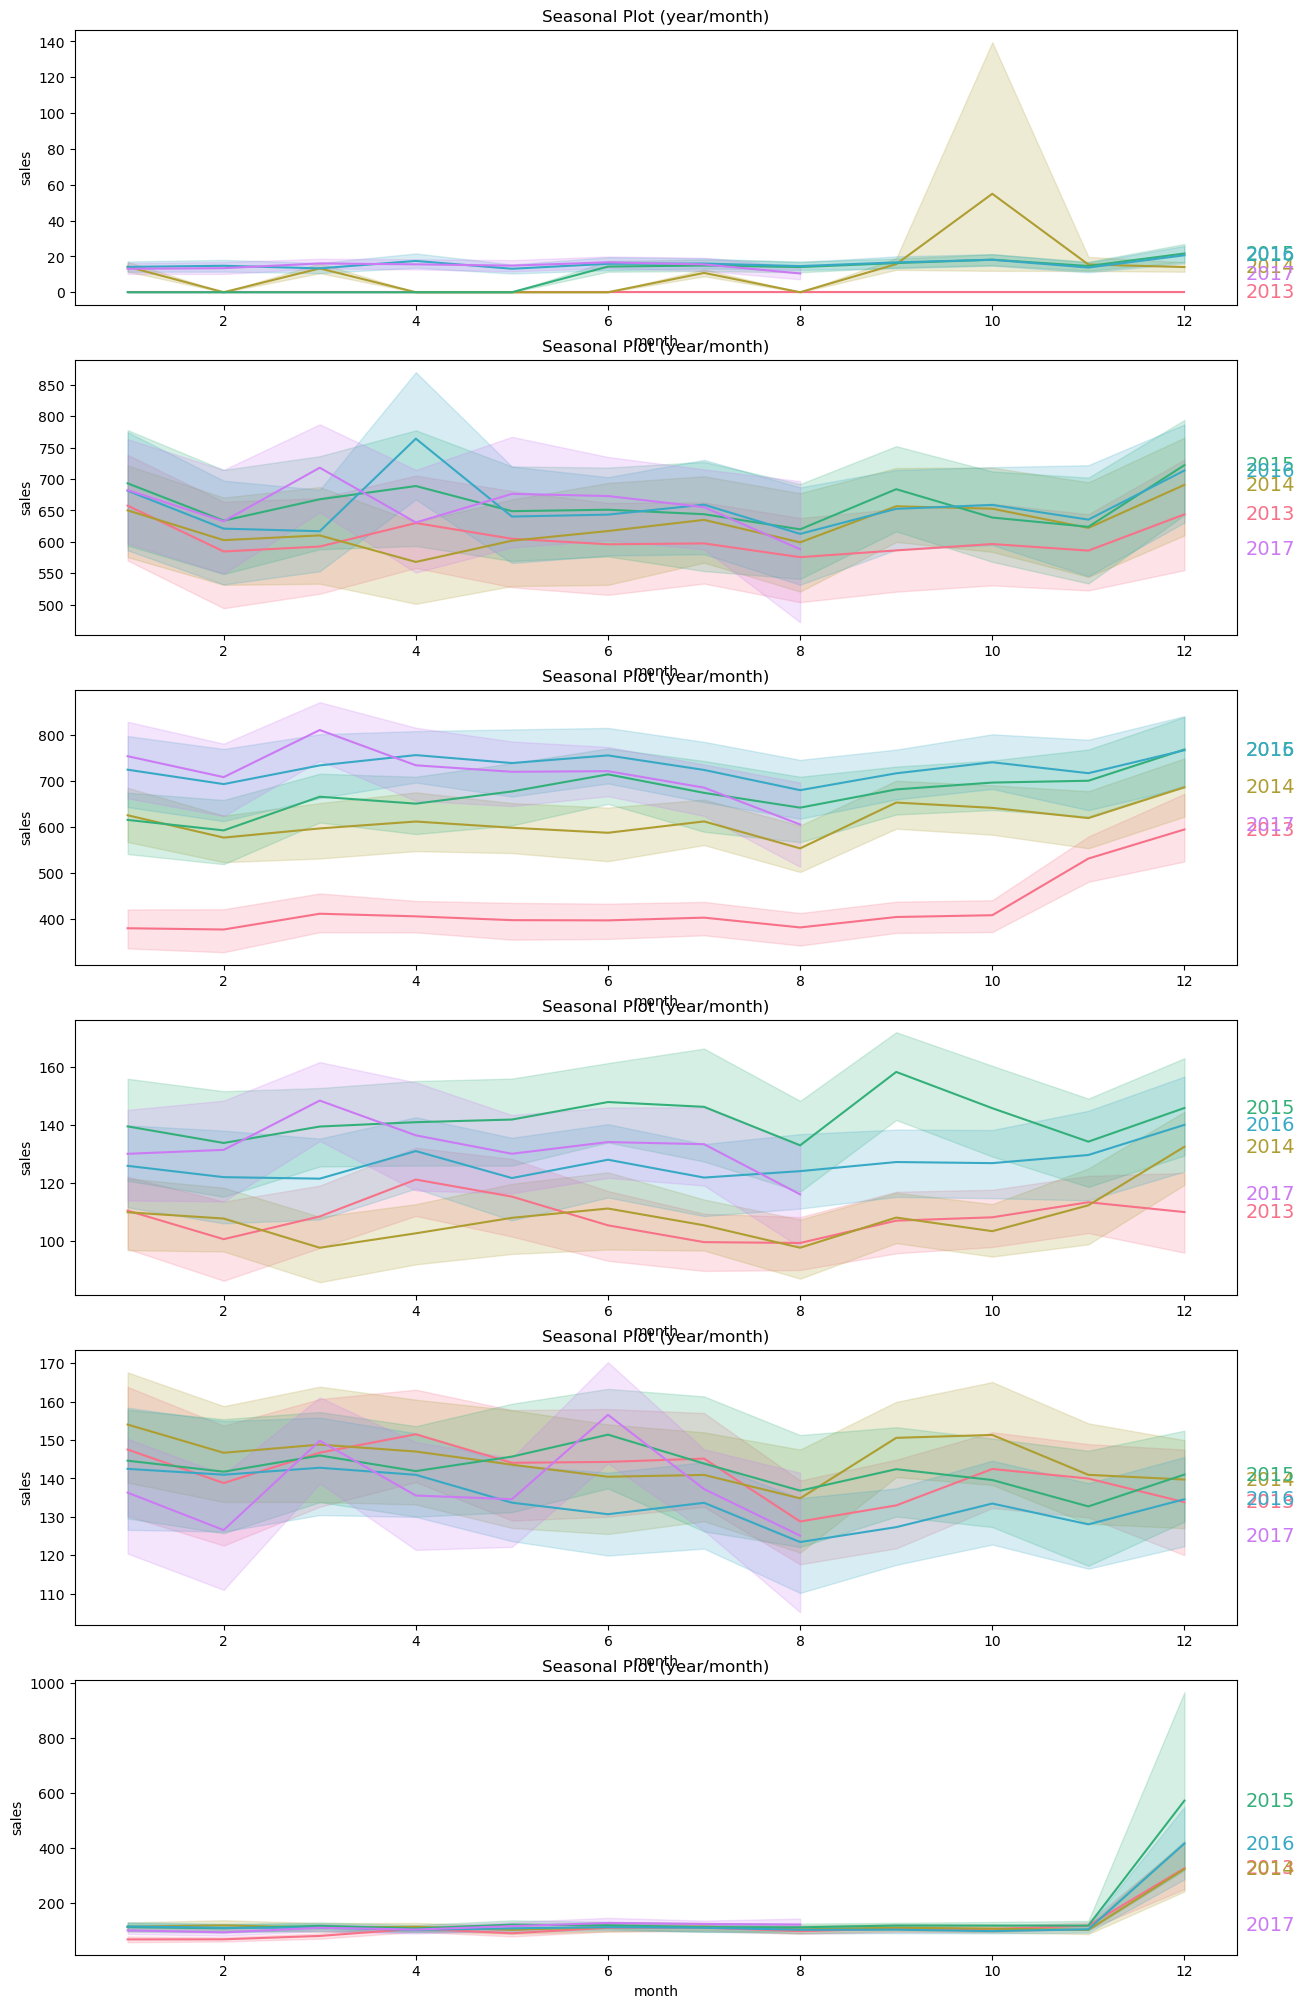

In [14]:
fig, axes = plt.subplots(6, 1, figsize = (15,25))
for n, ax in enumerate(axes):
    seasonal_plot(X = fl.loc[fl.family == cols[n+6], ['year', 'month']],
                  y = fl.loc[fl.family == cols[n+6], 'sales'], period = 'year', freq = 'month', ax=ax)
plt.show()

###### `In some cases there're yearly cycles`

#### Periodigram

/home/jovyan/work/store_sales/ts_tools.py:37: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  fs = pd.Timedelta("1Y") / pd.Timedelta("1D")


<AxesSubplot: title={'center': 'Periodogram'}, ylabel='Variance'>

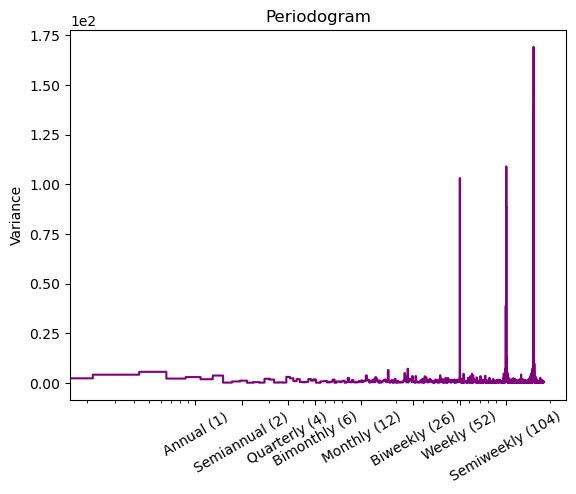

In [15]:
plot_periodogram(fl.loc[fl.family == cols[10], 'sales'].dropna())

###### `There're biweekly cycles also (maybe due to salaries on 15th and 30th)`

In [16]:
y = full.groupby(['date', 'store_nbr', 'family'])['sales'].mean().unstack(['store_nbr', 'family'])

In [17]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

In [18]:
fourier1 = CalendarFourier(freq='y', order=2)
fourier2 = CalendarFourier(freq='m', order=2)

In [19]:
dp = DeterministicProcess(y.index.to_period('D'), order = 1, seasonal=True, additional_terms=[fourier1, fourier2])

In [20]:
X = dp.in_sample()

<AxesSubplot: xlabel='date'>

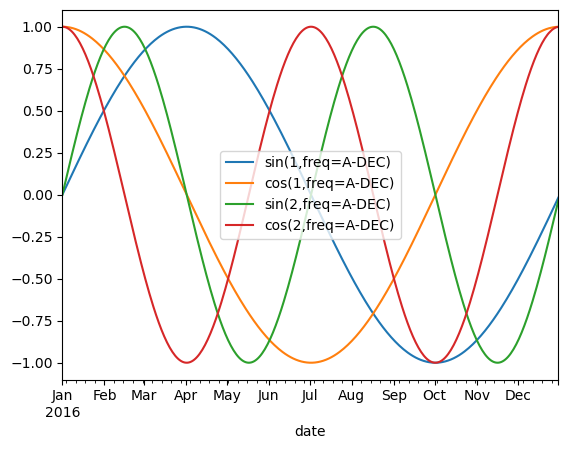

In [21]:
# annual terms
X.loc['2016', X.columns[-8:-4]].plot()

<AxesSubplot: xlabel='date'>

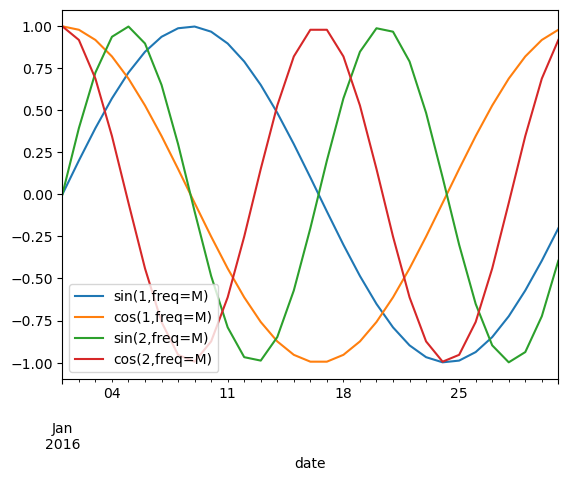

In [22]:
#monthly and biweekly
X.loc['2016-01', X.columns[-4:]].plot()

###### add dates of salaries

In [23]:
X.index = X.index.to_timestamp()

In [24]:
total = full.join(X)

In [25]:
total['salary'] = 0

In [26]:
total.loc[total.index.day == 15, 'salary'] = 1

In [27]:
from pandas.tseries.offsets import MonthEnd

In [28]:
last_days_of_month = (total.index + MonthEnd(0)).unique()

In [29]:
total.loc[total.index.isin(last_days_of_month), 'salary'] = 1

In [30]:
total.loc[total.salary == 1].index.unique()

DatetimeIndex(['2013-01-15', '2013-01-31', '2013-02-15', '2013-02-28',
               '2013-03-15', '2013-03-31', '2013-04-15', '2013-04-30',
               '2013-05-15', '2013-05-31',
               ...
               '2017-04-15', '2017-04-30', '2017-05-15', '2017-05-31',
               '2017-06-15', '2017-06-30', '2017-07-15', '2017-07-31',
               '2017-08-15', '2017-08-31'],
              dtype='datetime64[ns]', name='date', length=112, freq=None)

#### Deseason the data and del outliers

###### del outliers

In [31]:
from sklearn.neighbors import LocalOutlierFactor
lof = LocalOutlierFactor()

In [32]:
total_train = total.dropna()

In [33]:
#Search target outliers in every sku
total_train.loc[:, 'outliers'] =\
    total_train.groupby(["store_nbr", "family"],
        group_keys=False)[['sales']].apply(
            lambda x : pd.DataFrame(lof.fit_predict(x),
                index = total_train.index.unique(), columns=['sales']))

/tmp/ipykernel_24171/506922795.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_train.loc[:, 'outliers'] =\


In [34]:
#merge outliers
total = total.reset_index().merge(total_train.reset_index()[["date", "store_nbr", "family", "outliers"]], how = 'left').set_index('date')

###### Example for 1 ts

In [35]:
mask_ = (total_train.store_nbr == y.columns[10][0]) &\
                    (total_train.family == y.columns[10][1])

<AxesSubplot: xlabel='date', ylabel='sales'>

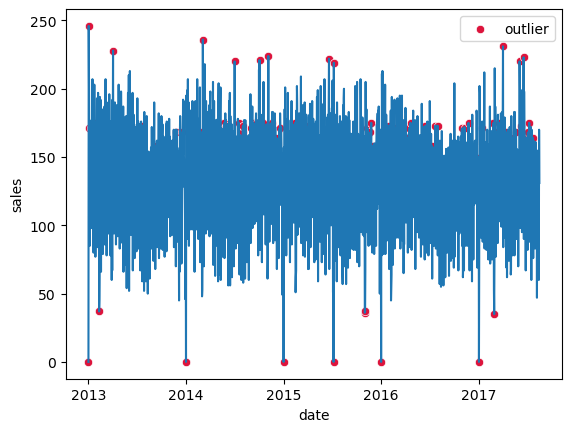

In [36]:
ax = sns.lineplot(data = total_train.loc[mask_], x = 'date', y='sales')
sns.scatterplot(data = total_train.loc[mask_ & (total_train.loc[mask_, 'outliers'] == -1)], x = 'date', y='sales', color="crimson", label="outlier", ax=ax)

In [37]:
total_train = total_train.loc[total_train.outliers != -1]

In [38]:
total_train = total_train.drop("outliers", axis = 1)

###### Check if it's enough features for seasonal comps by 1 step forecasting

In [39]:
from catboost import CatBoostRegressor

In [40]:
cat = CatBoostRegressor(silent=True)

In [41]:
mask_ = (total_train.store_nbr == y.columns[10][0]) &\
                    (total_train.family == y.columns[10][1])

In [42]:
X_ = total_train.loc[mask_].drop('sales', 1)
y_ = total_train.loc[mask_, 'sales']

/tmp/ipykernel_24171/2757991606.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_ = total_train.loc[mask_].drop('sales', 1)


In [43]:
# fit with default params just for example
cat.fit(X_, y_,
           cat_features = np.where(X_.dtypes.astype(
                    'str').isin([
                    'int64', 'category'
                    ]).values)[0])
#trend+seasonal comp
y_s = cat.predict(X_)
y_deseason = y_ - y_s

/opt/conda/lib/python3.10/site-packages/catboost/core.py:1222: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,


<AxesSubplot: xlabel='date'>

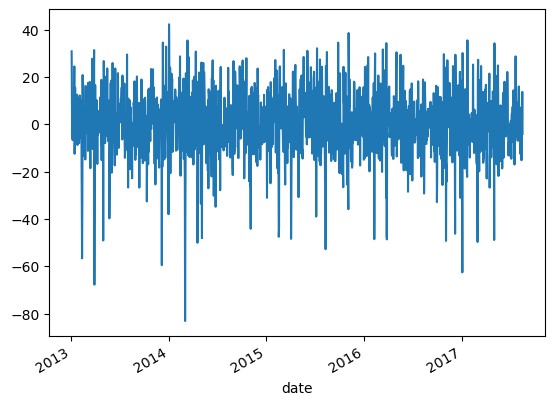

In [44]:
y_deseason.plot()

/home/jovyan/work/store_sales/ts_tools.py:37: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  fs = pd.Timedelta("1Y") / pd.Timedelta("1D")


<AxesSubplot: title={'center': 'Periodogram'}, ylabel='Variance'>

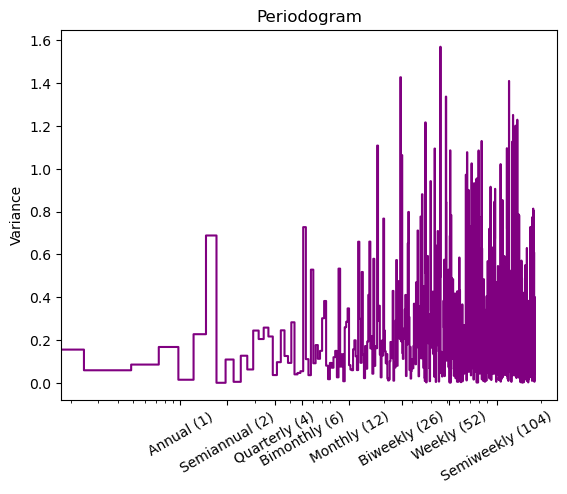

In [45]:
plot_periodogram(y_deseason)

##### `reduced for 2 orders`

### Investigating serial dependences

In [46]:
from statsmodels.graphics.tsaplots import plot_pacf

/opt/conda/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


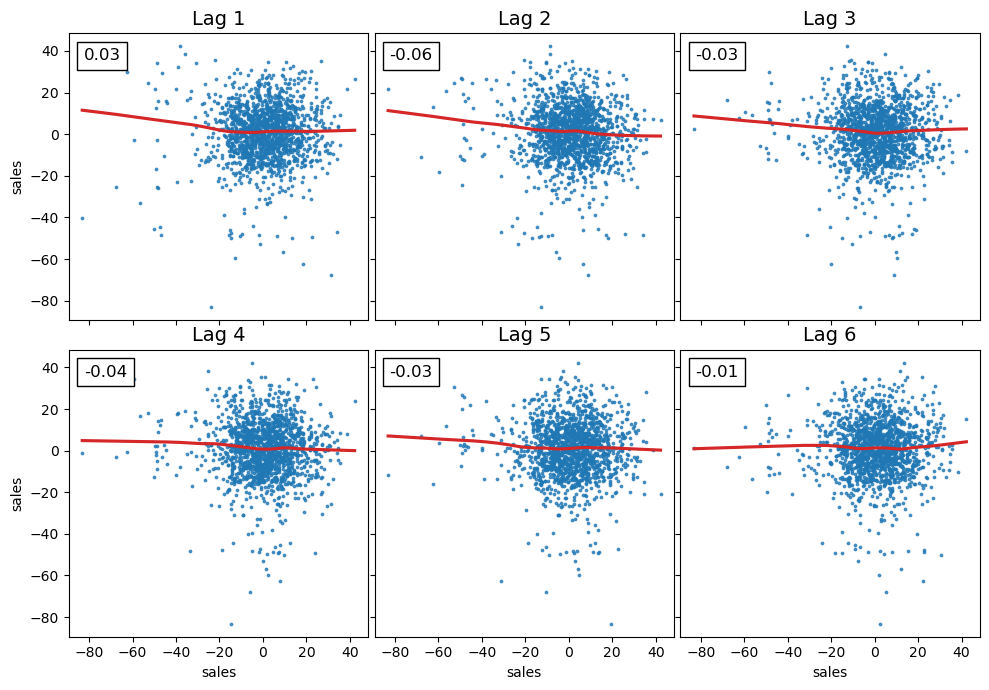

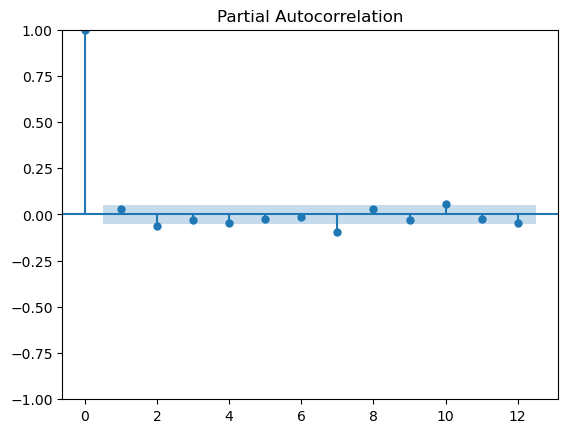

In [47]:
_ = plot_lags(y_deseason, lags=6, nrows=2, figsize = (10,7))
_ = plot_pacf(y_deseason, lags=12)

##### `in the most cases ther're no valued lags`

### Lags, MAs, adding multitarget

In [48]:
#add few lags
lags = total.groupby(['store_nbr', 'family'], group_keys=False)['sales'].apply(lambda x : make_lags(x, 3))

In [49]:
mas = total.groupby(['store_nbr', 'family'], group_keys=False)['sales'].apply(lambda x : make_mas(x, np.arange(2,7)))

In [50]:
mas2 = total.groupby(['store_nbr', 'family'], group_keys=False)['sales'].apply(lambda x : make_mas(x, np.arange(30, 91, 30)))

In [51]:
ys = total.groupby(['store_nbr', 'family'], group_keys=False)['sales'].apply(lambda x : make_multistep_target(x, 16, 'sales'))

In [52]:
df = pd.concat([total, lags, mas, mas2, ys], axis = 1)

In [53]:
target_df = df.dropna(subset=['y_lag_1', 'y_lag_2', 'y_lag_3', 'MA_2', 'MA_3', 'MA_4', 'MA_5', 'MA_6', 'MA_30', 'MA_60', 'MA_90'])

In [54]:
target_df.columns

Index(['store_nbr', 'family', 'sales', 'onpromotion', 'day', 'week', 'month',
       'year', 'trend', 's(1,7)', 's(2,7)', 's(3,7)', 's(4,7)', 's(5,7)',
       's(6,7)', 's(7,7)', 'sin(1,freq=A-DEC)', 'cos(1,freq=A-DEC)',
       'sin(2,freq=A-DEC)', 'cos(2,freq=A-DEC)', 'sin(1,freq=M)',
       'cos(1,freq=M)', 'sin(2,freq=M)', 'cos(2,freq=M)', 'salary', 'outliers',
       'y_lag_1', 'y_lag_2', 'y_lag_3', 'MA_2', 'MA_3', 'MA_4', 'MA_5', 'MA_6',
       'MA_30', 'MA_60', 'MA_90', 'sales_1', 'sales_2', 'sales_3', 'sales_4',
       'sales_5', 'sales_6', 'sales_7', 'sales_8', 'sales_9', 'sales_10',
       'sales_11', 'sales_12', 'sales_13', 'sales_14', 'sales_15', 'sales_16'],
      dtype='object')

### Add external features

In [55]:
#info about stores
stores = pd.read_csv('input_data/stores.csv',
        dtype={
        'store_nbr': 'category'
    }
)

In [56]:
target_df = target_df.reset_index().merge(stores, 'left', on = 'store_nbr').set_index('date')

In [57]:
#oil prices
oil = pd.read_csv('input_data/oil.csv',
       parse_dates = True,
       infer_datetime_format=True,
       index_col=0
)

In [58]:
target_df = target_df.join(oil)

In [59]:
target_df['dcoilwtico'] = target_df['dcoilwtico'].fillna(method = 'ffill')

In [60]:
#total transactions
tr = pd.read_csv('input_data/transactions.csv',
        dtype={
        'store_nbr': 'category'
        },
       parse_dates = ['date'],
       infer_datetime_format=True)

In [61]:
target_df = target_df.reset_index().merge(tr, 'left', on = ['date', 'store_nbr']).set_index('date')

In [62]:
#fill 0 to empty transactions
target_df.transactions = target_df.transactions.fillna(0)

In [63]:
#MA for transactions
target_df[['tr_10', 'tr_20', 'tr_30']] =\
    target_df.groupby(['store_nbr', 'family'],
                        group_keys=False)['transactions'].apply(lambda x :\
                                                                    make_mas(x, np.arange(10, 31, 10))).values

In [64]:
#MA for oil price
target_df[['oil_10', 'oil_20', 'oil_30']] =\
    target_df.groupby(['store_nbr', 'family'],
                        group_keys=False)['dcoilwtico'].apply(lambda x :\
                                                                    make_mas(x, np.arange(10, 31, 10))).values

In [65]:
#holidays
hd = pd.read_csv('input_data/holidays_events.csv',
       parse_dates = ['date'],
       infer_datetime_format=True)

In [66]:
#del transferres holidays
hd = hd.loc[hd.transferred == False]

In [67]:
hd = hd.set_index('date')

In [68]:
#Country
hd_n = hd.loc[hd.locale == 'National']

In [69]:
#local
hd_l = hd.loc[hd.locale == 'Local']

In [70]:
#regional
hd_r = hd.loc[hd.locale == 'Regional']

In [71]:
hd_n['national'] = 1

/tmp/ipykernel_24171/3754618716.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hd_n['national'] = 1


In [72]:
#Add national holidays
target_df = target_df.join(hd_n['national'])
target_df['national'].fillna(0, inplace=True)
target_df['national'] = target_df['national'].astype('int')

In [73]:
target_df['national'].sum()

240570

In [74]:
hd_l = hd_l.rename({'locale_name':'city'}, axis = 1)

In [75]:
hd_l['local'] = 1

In [76]:
#Add local holidays
target_df = target_df.reset_index().merge(hd_l[['city', 'local']].reset_index(), 'left', ['date', 'city']).set_index('date')
target_df['local'] = target_df['local'].fillna(0)
target_df['local'] = target_df['local'].astype('int')

In [77]:
target_df['local'].sum()

12078

In [78]:
hd_r = hd_r.rename({'locale_name':'state'}, axis = 1)
hd_r['regional'] = 1

In [79]:
#Add regional holidays
target_df = target_df.reset_index().merge(hd_r[['state', 'regional']].reset_index(), 'left', ['date', 'state']).set_index('date')
target_df['regional'] = target_df['regional'].fillna(0)
target_df['regional'] = target_df['regional'].astype('int')

In [80]:
target_df['regional'].sum()

1023

In [81]:
target_df['holiday'] = target_df[['national', 'local', 'regional']].sum(1)

In [84]:
#to avoid data_leakage
target_df = target_df.drop(['sales', 'dcoilwtico', 'transactions'], axis=1)

In [91]:
target_df.to_csv('data.csv')

In [46]:
# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int